In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.dates as mdates
#from cftime import DatetimeNoLeap

%config InlineBackend.figure_format = 'retina'

### Temperature

In [2]:
tas_ds = xr.open_dataset("tas-greenland-merged.nc")
# convert to celsius
tas = tas_ds.tas - 273.15
# copy attributes to get nice figure labels and change kelvin to celsius
tas.attrs = tas_ds.tas.attrs
tas.attrs["units"] = "deg C"

Mean annual temperature

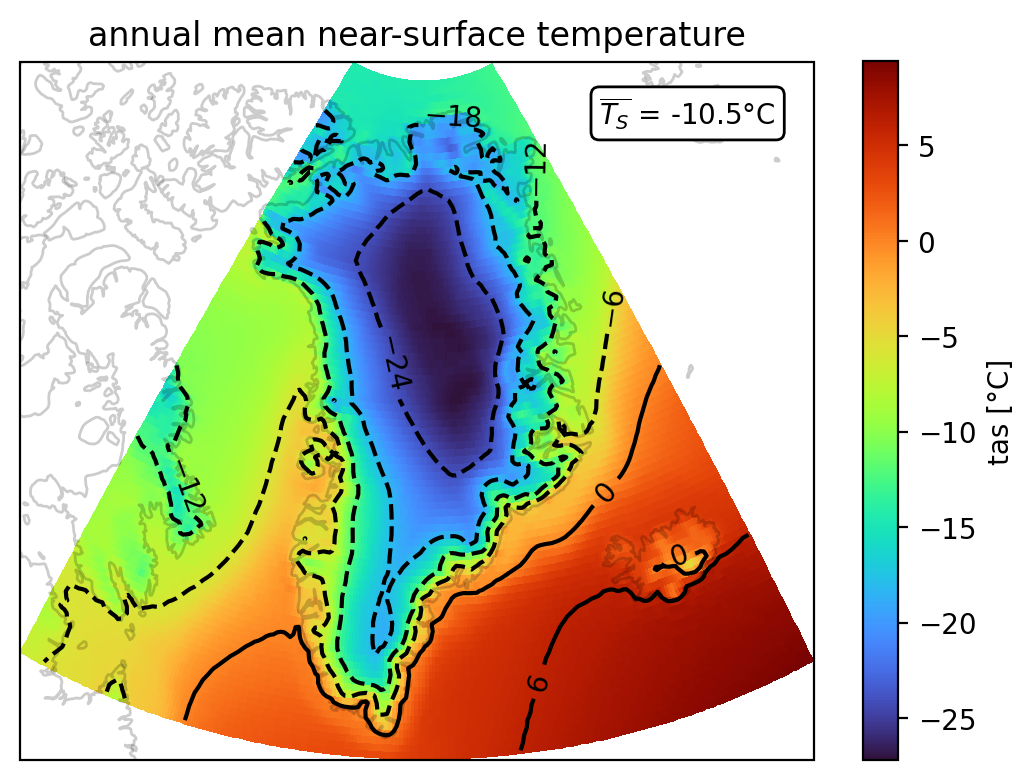

In [16]:
# sellonlatbox,288,349,59,85
proj = ccrs.Orthographic(central_longitude=-41, central_latitude=72)
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# dataset plotting
tas.mean(dim='time').plot(ax=ax, transform=trans, center=False, cmap='turbo',
                          cbar_kwargs=dict(shrink=0.945, label="tas [°C]"))
cs = tas.mean(dim='time').plot.contour(ax=ax, transform=trans, colors='k',
                                       levels=8, center=False, add_colorbar=False)
ax.clabel(cs)

# add mean temperature as text label
props = dict(boxstyle='round', facecolor='white')
tas_mean = tas.mean(dim=['lon','lat','time']).item()
ax.text(0.73, 0.9, rf"$\overline{{T_S}}$ = {np.round(tas_mean, 1)}°C",
        verticalalignment="bottom", transform=ax.transAxes, bbox=props)

ax.coastlines(alpha=0.2)
#ax.gridlines()
ax.set_title("annual mean near-surface temperature")
plt.savefig("figs/tas-annual-mean.png", dpi=300, bbox_inches="tight")

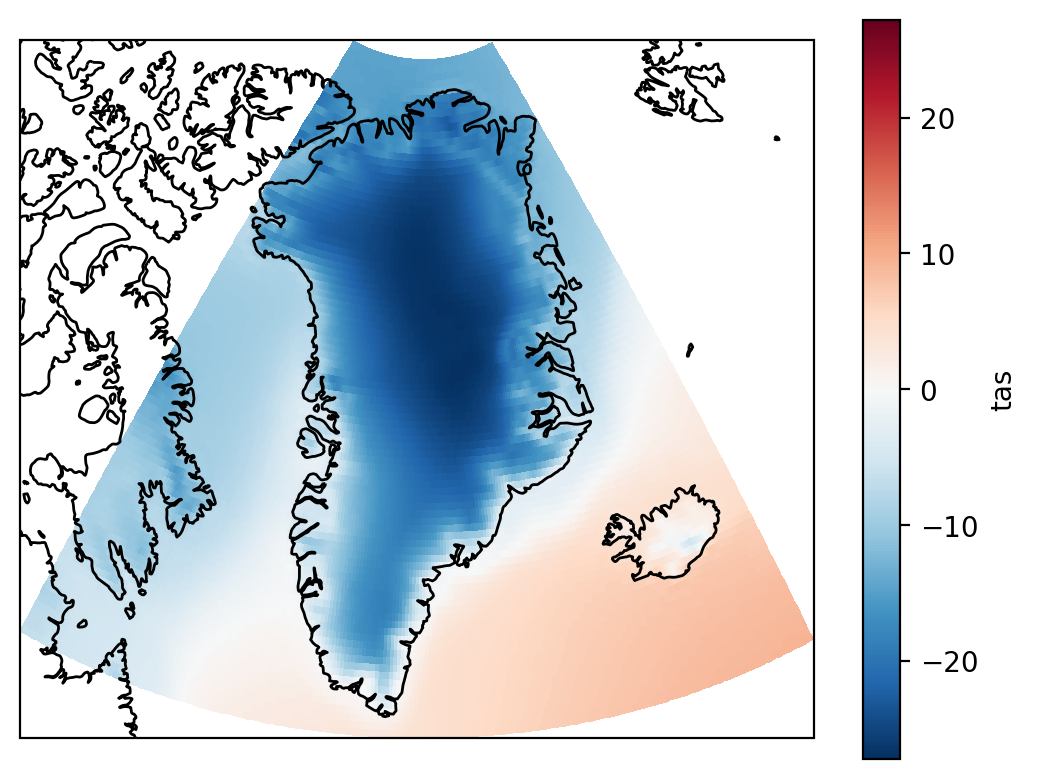

In [4]:
# alternative way of plotting by saving xarray plot-method object
p = tas.mean(dim='time').plot(
    transform=trans,
    subplot_kws=dict(projection=proj),
)
p.axes.coastlines()
plt.show()

Multi-year mean temperature

In [5]:
# additionally get standard deviation
tas_std = xr.open_dataset("tas-greenland-merged-std.nc")['tas']

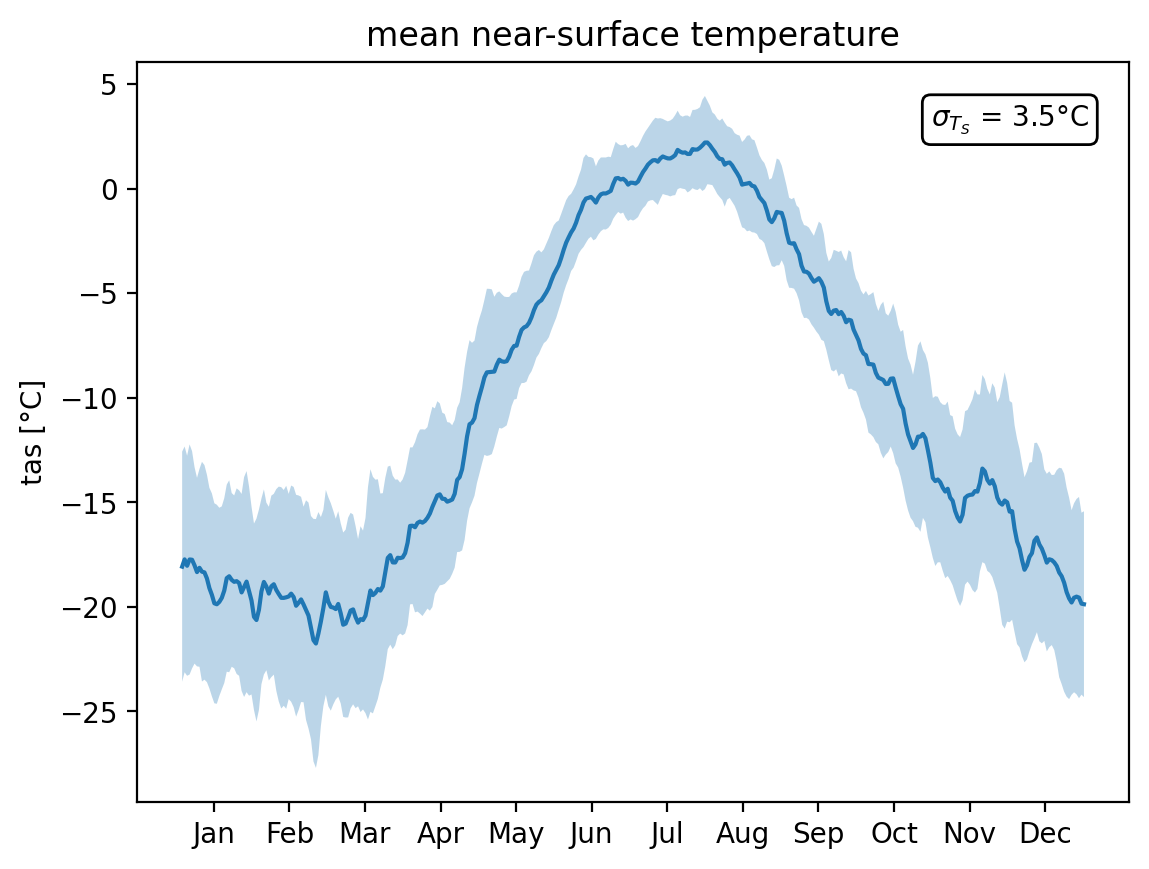

In [6]:
# fill_between doesn't work out of the box with xarray,
# hence, converting to datetime objects & numpy arrays
xtime = tas.indexes['time'].to_datetimeindex(unsafe=True)
tas_mean = tas.mean(dim=['lon','lat']).values
tas_std_mean = tas_std.mean(dim=['lon','lat']).values

fig, ax = plt.subplots()

ax.plot(xtime, tas_mean)
ax.fill_between(xtime, tas_mean-tas_std_mean, tas_mean+tas_std_mean, alpha=.3)

# add mean standard deviation as text label
props = dict(boxstyle='round', facecolor='white')
ax.text(0.8, 0.9, rf"$\sigma_{{T_S}}$ = {np.round(np.mean(tas_std_mean), 1)}°C",
        verticalalignment="bottom", transform=ax.transAxes, bbox=props)

# change x tick locations
# xlim actually gives start and end coordinate of plot window
start, end = ax.get_xlim()
# hence, manually adjusting x tick positions
ax.xaxis.set_ticks(np.arange(start+31, end-30, 30.5))
# change date format to month
dt_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(dt_fmt)

ax.set_title("mean near-surface temperature")
ax.set_ylabel("tas [°C]")
plt.savefig("figs/tas-seasonality.png", dpi=300, bbox_inches="tight")

### Precipitation

In [38]:
pr = xr.open_dataset("pr-greenland-merged.nc")['pr'] *24*60*60
pr.attrs['units'] = 'mm d-1'

max pr = 8.837168 mm d-1


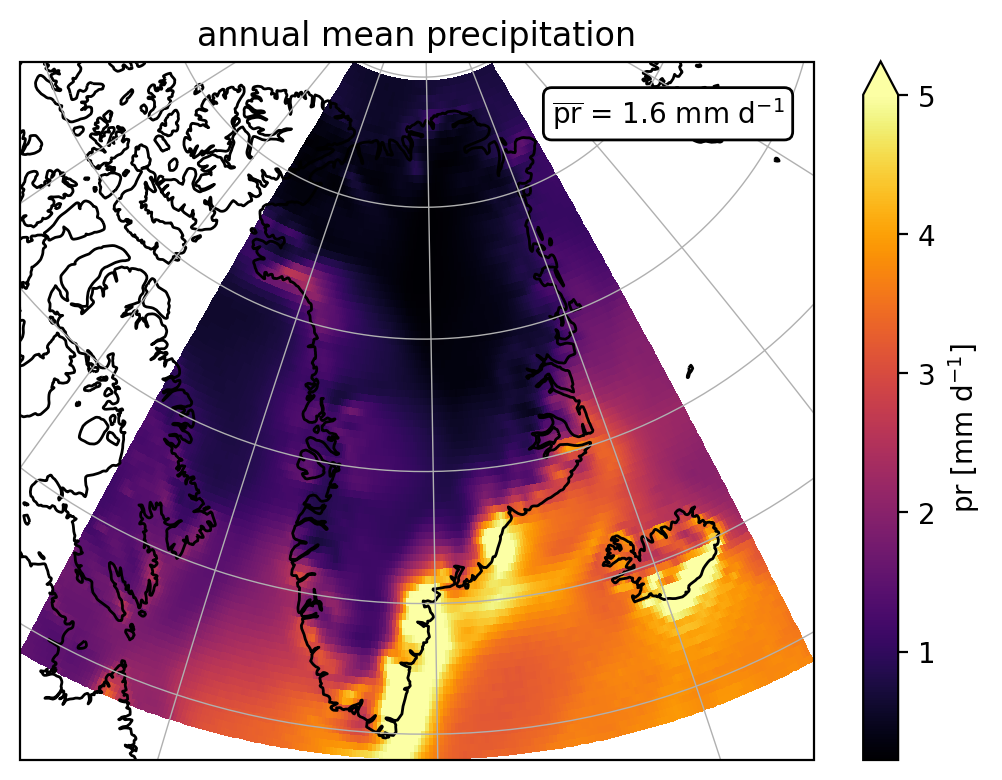

In [37]:
proj = ccrs.Orthographic(-41, 72)
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# dataset plotting
pr.mean(dim='time').plot(ax=ax, transform=trans, cmap='inferno', vmax=5,
                         cbar_kwargs=dict(shrink=0.945, label=r"pr [mm d$^{-1}$]"))

# add mean precipitation as text label
props = dict(boxstyle='round', facecolor='white')
pr_mean = pr.mean(dim=['lon','lat','time']).item()
ax.text(0.67, 0.9, rf"$\overline{{\rm{{pr}}}}$ = {np.round(pr_mean, 1)} mm d$^{{-1}}$",
        verticalalignment="bottom", transform=ax.transAxes, bbox=props)

ax.coastlines()
ax.gridlines(lw=.5)
ax.set_title("annual mean precipitation")
plt.savefig("figs/pr-annual-mean.png", dpi=300, bbox_inches="tight")

# output maximum precipitation as scale in figure is cropped
print("max pr =", pr.mean(dim='time').max().values, "mm d-1")

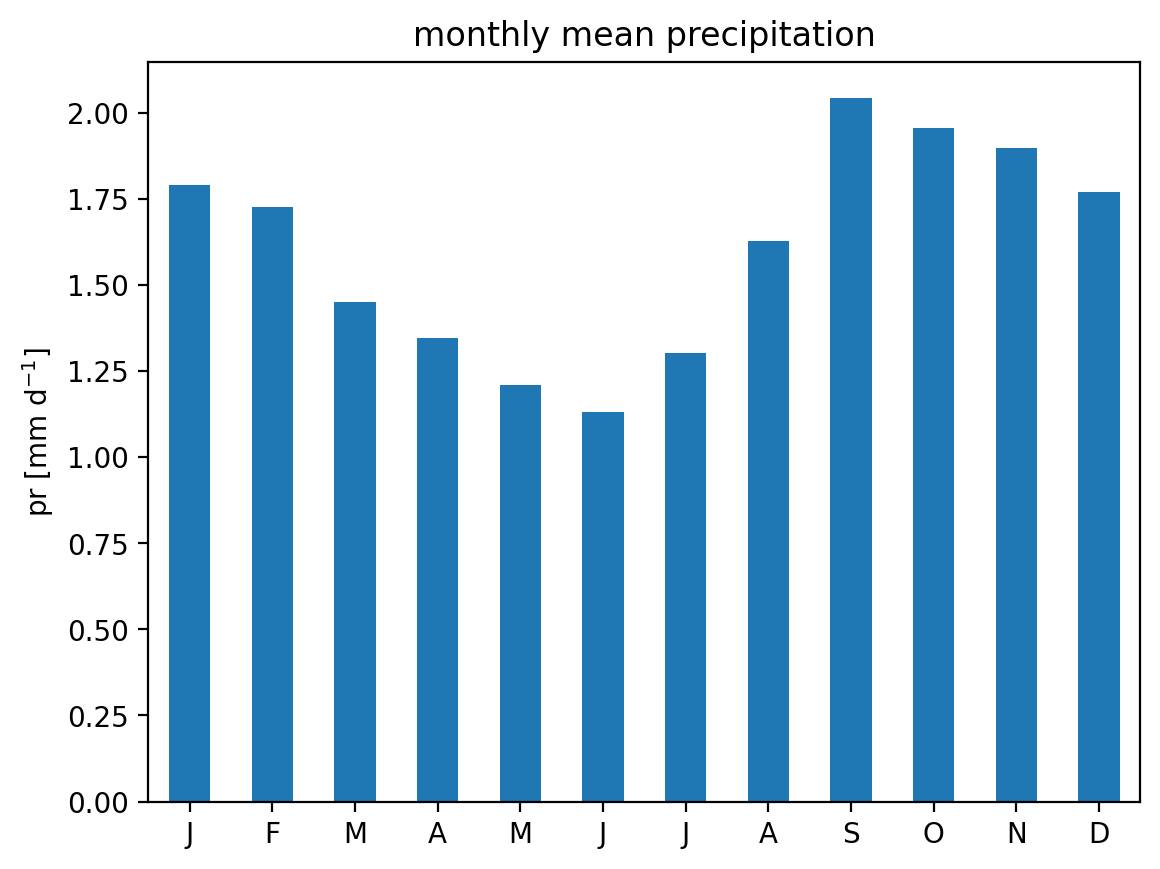

In [60]:
# compute multi-year monthly mean precipitation
# and convert to series as xarray as no bar plot routine yet
pr_m_mean = pr.groupby('time.month').mean(dim=['lon', 'lat', 'time']).to_series()

fig, ax = plt.subplots()
pr_m_mean.plot.bar(ax=ax) # use pandas bar-plot method

# change x tick labels (manually, unfortunately)
ax.xaxis.set_ticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], rotation=0)

# further beautification
ax.set_title("monthly mean precipitation")
ax.set_ylabel(r"pr [mm d$^{-1}$]")
ax.set_xlabel(None)

plt.savefig("figs/pr-seasonality.png", dpi=300, bbox_inches="tight")